# Multi-channel, bidirectional optogenetics

Cleo supports the simultaneous use of multiple {class}`~cleo.opto.Light` devices, multiple channels per device, and multiple opsins per neuron group.
Here' we'll see how to use all these features.

In [1]:
# boilerplate
%load_ext autoreload
%autoreload 2
from brian2 import *
import matplotlib.pyplot as plt

import cleo
from cleo import *

cleo.utilities.style_plots_for_docs()

# numpy faster than cython for lightweight example
prefs.codegen.target = "numpy"
# for reproducibility
np.random.seed(1866)

# colors
c = {
    "main": "#C500CC",
    "473nm": "#72b5f2",
    "590nm": (1, 0.875, 0),
}

## Network setup
We'll use excitatory and inhibitory populations of [exponential integrate-and-fire neurons](https://neuronaldynamics.epfl.ch/online/Ch5.S2.html).

In [2]:
n = 500
ng = NeuronGroup(
    n,
    """
    dv/dt = (
        -(v - E_L)
        + Delta_T*exp((v-theta)/Delta_T)
        + Rm*(I_exc + I_inh + I_bg + I_enphr)
    ) / tau_m + sigma*sqrt(2/tau_m)*xi: volt
    I_exc : amp
    I_inh : amp
    I_enphr : amp
    """,
    threshold="v > -10*mV",
    reset="v=E_L",
    namespace={
        "tau_m": 20 * ms,
        "Rm": 500 * Mohm,
        "theta": -50 * mV,
        "Delta_T": 2 * mV,
        "E_L": -70 * mV,
        "sigma": 5 * mV,
        "I_bg": 60 * pamp,
    },
)
ng.v = np.random.uniform(-70, -50, n) * mV

W = 1 * mV
p_S = 0.3
n_neighbors = 40
S_ee = Synapses(ng, model="w: 1", on_pre="v_post+=W*w/sqrt(N)")
S_ee.connect(condition="abs(i-j)<=n_neighbors and i!=j")
S_ee.w = np.exp(np.random.randn(int(S_ee.N - 0))) * np.random.choice(
    [-1, 1], int(S_ee.N - 0)
)

spike_mon = SpikeMonitor(ng)
# for visualizing currents
Imon = StateMonitor(ng, ("I_exc", "I_inh", "I_enphr"), record=range(50))
net = Network(ng, S_ee, spike_mon, Imon)
sim = cleo.CLSimulator(net)

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='x [um]', ylabel='y [um]', zlabel='z [um]'>)

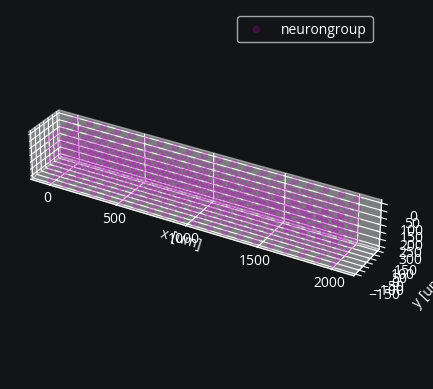

In [3]:
from cleo.coords import assign_coords_grid_rect_prism

xmax_mm = 2
assign_coords_grid_rect_prism(
    ng, xlim=(0, xmax_mm), ylim=(-0.15, 0.15), zlim=(0, 0.3), shape=(20, 5, 5)
)
cleo.viz.plot(ng, colors=[c["main"]])

## Injecting a multi-channel `Light`

A {class}`~cleo.opto.Light` device can have multiple channels; all the user needs is to specify the coordinates (and optionally direction) of each light source (channel).
A {class}`~cleo.opto.LightModel` (e.g., that of an optical fiber) defines how light propagates from each source.

Here we inject 590 nm light for activating Vf-Chrimson.
Lacking a more rigorous quantification, we assume absorption and scattering coefficients of 590 nm light in the brain are roughly 0.8 times that of 470 nm light (see [Jacques 2013](https://iopscience.iop.org/article/10.1088/0031-9155/58/11/R37/meta) for some justification).

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='x [um]', ylabel='y [um]', zlabel='z [um]'>)

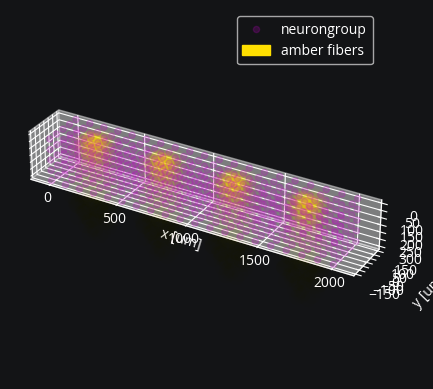

In [4]:
from cleo.light import Light, OpticFiber
from cleo.opto import vfchrimson_4s, enphr3_3s

n_fibers = 4
coords = np.zeros((n_fibers, 3))
end_space = 1 / (2 * n_fibers)
coords[:, 0] = np.linspace(end_space, 1 - end_space, n_fibers) * xmax_mm
coords[:, 1] = -0.025
amber_fibers = Light(
    name="amber fibers",
    coords=coords * mm,
    light_model=OpticFiber(K=0.125 * 0.8 / mm, S=7.37 * 0.8 / mm),
    wavelength=590 * nmeter,
)
sim.inject(amber_fibers, ng)
vfc = vfchrimson_4s()
enphr3 = enphr3_3s()
sim.inject(vfc, ng, Iopto_var_name="I_exc")
# sim.inject(enphr3, ng, Iopto_var_name="I_enphr", rho_rel=1)
cleo.viz.plot(ng, colors=[c["main"]], sim=sim)

## Bidirectional control via a second opsin
Here we will demonstrate increasing and decreasing activity in the same experiment by injecting an inhibitory opsin with a minimally overlapping activation spectrum.
Alternatively, we could achieve bidirectional control with excitatory opsins on excitatory and inhibitory neurons.

We will use the anion channel GtACR2 which is maximally activated by 470 nm light.

Let's first visualize how the action spectra for the two opsins overlap:

DimensionMismatchError: Cannot perform comparison 4.7e+11 m^-1 < 380, units do not match (units are m^-1 and 1).

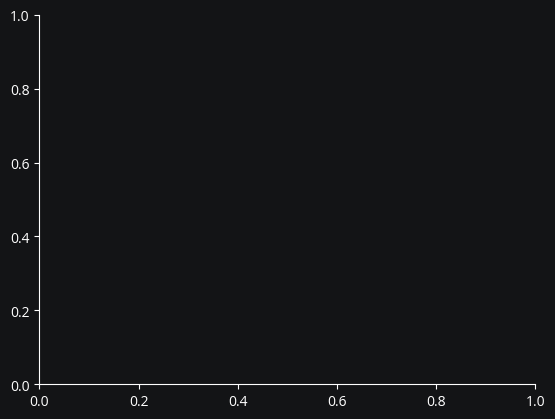

In [5]:
gtacr2 = cleo.opto.gtacr2_4s()
cleo.light.plot_spectra(vfc, gtacr2)

We see that GtACR2 will be totally unaffected by amber (590 nm) light, while Vf-Chrimson will be slightly activated by blue (470 nm) light.

In [17]:
coords[:, 1] = 0.025
blue_fibers = Light(
    name="blue fibers",
    coords=coords * mm,
    light_model=cleo.light.fiber473nm(),
)
sim.inject(blue_fibers, ng)
sim.inject(gtacr2, ng, Iopto_var_name="I_inh")
cleo.viz.plot(ng, colors=[c["main"]], sim=sim)

## Open-loop stimulation
We will now design a stimulus pattern to demonstrate bidirectional control segregated by channel.

In [18]:
from cleo.ioproc import LatencyIOProcessor


class OpenLoopOpto(LatencyIOProcessor):
    def __init__(self):
        super().__init__(sample_period=1 * ms)

    # since this is open-loop, we don't use state_dict
    def process(self, state_dict, time_ms):
        amplitude_mW_mm2 = 1
        time_offsets = np.array([0, -20, -40, -60])
        t = time_ms + time_offsets
        amber = ((t >= 20) & (t < 40)) * amplitude_mW_mm2
        blue = ((t >= 60) & (t < 63)) * amplitude_mW_mm2

        # return output dict and time
        return ({"amber fibers": amber, "blue fibers": blue}, time_ms)


sim.set_io_processor(OpenLoopOpto())

### Run simulation and plot results

In [19]:
sim.reset()
sim.run(200 * ms)

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(spike_mon.t / ms, spike_mon.i[:], ",")
ax1.set(ylabel="neuron index", title="spiking")

ax2.step(
    blue_fibers.t_ms,
    blue_fibers.irradiance + np.arange(n_fibers) * 1.3 + 0.1,
    c=c["473nm"],
)
ax2.step(
    amber_fibers.t_ms, amber_fibers.irradiance + np.arange(n_fibers) * 1.3, c=c["590nm"]
)
ax2.set(
    yticks=[],
    ylabel="intensity per channel",
    title="photostimulation",
    xlabel="time (ms)",
)

As you can see, Vf-Chrimson has fast dynamics, enabling high-frequency control.
GtACR2, on the other hand, continues acting long after the light is removed due to its slow deactivation kinetics.
We can confirm this by plotting the current from each of the opsins in the first segment of neurons:

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(Imon.t / ms, Imon.I_exc.T / namp, lw=0.2, c=c["590nm"])
ax1.set(title="Vf-Chrimson current", ylabel="$I_{exc}$ (nA)")
ax2.plot(Imon.t / ms, Imon.I_inh.T / namp, lw=0.2, c=c["473nm"])
ax2.plot(Imon.t / ms, Imon.I_enphr.T / namp, lw=0.2, c=c["590nm"])
ax2.set(title="GtACR2 current", ylabel="$I_{inh}$ (nA)")

We can also confirm that blue light has a non-negligible effect on Vf-Chrimson.

## Conclusion
As a recap, in this tutorial we've seen how to:
* configure a multi-channel {class}`~cleo.opto.Light` device,
* use more than one of them simultaneously, and
* inject multiple opsins of overlapping action spectra into the same network.